In [1]:
import pandas as pd
import numpy as np
import glob
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 600)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# import all flight history
flight_files = glob.glob('data_clean/flights/*.csv')

flight_files_list = []
for file in flight_files:
    df = pd.read_csv(file)
    flight_files_list.append(df)

flights = pd.concat(flight_files_list)

flights = flights.sort_values('registration').drop_duplicates(subset=['registration', 'flight_date', 'from_code', 'to_code', 'flight_No.'],keep='last')

In [3]:
fleets = pd.read_csv('data_clean/fleets.csv', index_col = 0)
fleets['registration'] = fleets['registration'].str.lower()

In [4]:
# merge flights of Air Canada and Air Canada Rouge
fleets.loc[lambda fleets: (fleets['company'] == 'Air Canada Rouge'), 'company'] = 'Air Canada'

# merge swoop with westjet
fleets.loc[lambda fleets: (fleets['company'] == 'Swoop'), 'company'] = 'WestJet'

In [5]:
# remove Air Georgian (very few flights)
fleets = fleets.drop(fleets[fleets['company'] == 'Air Georgian'].index)

In [6]:
fleets.company.value_counts()

Air Canada           419
WestJet              183
Air Transat           40
Air Inuit             32
Porter                29
Central Mountain      25
Air Creebec           21
Sunwing               20
First Air             18
Canadian North        15
Flair Airlines         9
Air North              8
Calm Air               4
Name: company, dtype: int64

# Create a dataframe contains flight information and airport locations
## Merge fleets and flights

In [7]:
flights = pd.merge(flights, fleets, on = 'registration')

## merge geographical location to the airports

In [8]:
airports = pd.read_csv('data_clean/world_airports.csv', index_col=0)
airports.head(2)

,airport ID,name,city,country,IATA,ICAO,lat,long,altitude,timezone,DST,database time zone,type,source
Column,,,,,,,,,,,,,,
0.0,1.0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282.0,10,U,Pacific/Port_Moresby,airport,OurAirports
1.0,2.0,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20.0,10,U,Pacific/Port_Moresby,airport,OurAirports


In [9]:
flights = pd.merge(flights, airports[['IATA', 'lat', 'long', 'country']], how = 'left', left_on = 'from_code', right_on = 'IATA').\
rename(columns = {'lat': 'from_lat', 'long':'from_long', 'country':'from_country'})

flights = pd.merge(flights, airports[['IATA', 'lat', 'long', 'country']], how = 'left', left_on = 'to_code', right_on = 'IATA').\
rename(columns = {'lat': 'to_lat', 'long':'to_long', 'country': 'to_country'})

flights = flights.drop(['IATA_x', 'IATA_y'], axis = 1)

# Further cleaning

In [10]:
# Some flight No. contain '()', remove them
flights['flight_No.'] = flights['flight_No.'].str.replace('(', "")
flights['flight_No.'] = flights['flight_No.'].str.replace(')', "")

In [11]:
# There are many reasons that a flight status is unknown. 
# But one thing can be sure that if the flight had a ATD information - actual departure time,
# it was not canceled and the travel occurred.
# Therefore, the unknown status can be changed into 'Landed' if the ATD column is not empty.
flights.loc[lambda flights: (flights['ATD'].notnull()) & (flights['status_clean'] == 'Unknown'), 'status_clean'] = 'Landed'

In [12]:
# drop rows that have no information of neither from and to
flights = flights.dropna(subset = ['from_city', 'to_city'], how = 'all')

# drop rows that have no flight number
flights = flights.dropna(subset = ['flight_No.'])

In [13]:
# add a new column indicating flight type: domestic or international
flights['flight_type'] = np.where((flights['from_country'] != 'Canada')|(flights['to_country'] != 'Canada'), 'international', 'domestic')
    
# some origins or destinations have null values. Deal with them.
flights.loc[lambda flights: (flights['from_country'].isnull())|(flights['to_country'].isnull()), 'flight_type'] = np.nan

Note: There are cases that flights were operated by Canadian airlines but flew within another country, eg. Boston to New York City. Such type of flights are also considered as international flight in this case.

# Set a time-frame for the analysis
The whole database covers flights from 2019-10-11 to recent. For this analysis, the focus will be on a shorter span of time - the time before and after the pandemic outbreak in Canada. So the timeframe is set in between January and mid-May.

In [14]:
flights['flight_date'] = pd.to_datetime(flights['flight_date'])

In [15]:
flights_frame = flights[(flights['flight_date'] >= '2020-02-01') & (flights['flight_date'] <= '2020-05-20')]

In [16]:
flights_frame.shape

(198651, 25)

More flights has unknown destination than unknown from-airports. This is highly possible that the planes had been canceled. Also, in many such cases, the flight status labeled as 'Unknown'. However, we can not infer how many of such flights were actually canceled or untracked. 

In [17]:
print('There are ' + str(flights_frame[(flights_frame['from_city'].notnull()) & (flights_frame['to_city'].isnull())].shape[0]) + \
      ' flights have known orgins but unknown destinations. Among them, ' + \
      str(flights_frame[(flights_frame['from_city'].notnull()) & (flights_frame['to_city'].isnull()) & (flights_frame['status_clean'] == 'Unknown') ].shape[0]) + \
     ' have unknown status. ' + '\n' + 'There are ' + \
     str(flights_frame[(flights_frame['from_city'].isnull()) & (flights_frame['to_city'].notnull())].shape[0]) +\
     ' flights have unkown origins but known destinations. Among them, ' +\
     str(flights_frame[(flights_frame['from_city'].isnull()) & (flights_frame['to_city'].notnull())& (flights_frame['status_clean'] == 'Unknown')].shape[0]) +\
     ' have unkown status.')

There are 3974 flights have known orgins but unknown destinations. Among them, 1287 have unknown status. 
There are 186 flights have unkown origins but known destinations. Among them, 8 have unkown status.


In [18]:
flights_frame.set_index('flight_date', inplace = True)

# Flight Analysis
This section is going to examine how the outbreaks of Covid-19 impact the number of flights of Canadian airline companies.

## No. of flights by day. (Remove canceled flights)

In [19]:
# a new df without any cancellation, but still contains unknown flights
no_cancel = flights_frame[flights_frame['status_clean'] != 'Canceled']

Text(2020-03-15, 2800, 'travel warning on March 13')

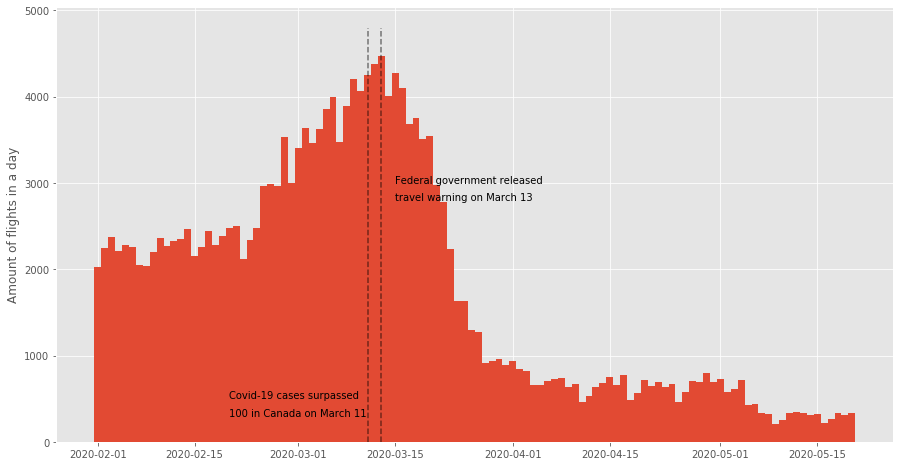

In [20]:
plt.figure(figsize = (15,8))
plt.bar(x = no_cancel.resample('1d').registration.count().index, 
        height = no_cancel.resample('1d').registration.count().values, 
        width=1.0)
plt.ylabel('Amount of flights in a day')
plt.vlines(x = '2020-03-11', ymin=0, ymax = 4800, linestyle = 'dashed', alpha = 0.5)
plt.vlines(x = '2020-03-13', ymin=0, ymax = 4800, linestyle = 'dashed', alpha = 0.5)
plt.text(x = '2020-02-20', y = 500, s = 'Covid-19 cases surpassed', ha='left')
plt.text(x = '2020-02-20', y = 300, s = '100 in Canada on March 11', ha='left')
plt.text(x = '2020-03-15', y = 3000, s = 'Federal government released')
plt.text(x = '2020-03-15', y = 2800, s = 'travel warning on March 13')

Compare to baseline: On March 11, the confirmed cases of Covid-19 surpassed 100 in Canada. The whole country had gradually came into a lockdown in the following days.Therefore, the baseline here is the median number of flights between Feburary and March 11. 

In [21]:
flights_daily = pd.DataFrame(no_cancel.resample('1d').registration.count()).rename(columns={'registration': 'flights'})
baseline = flights_daily.loc[:'2020-03-11']['flights'].median()
flights_daily['compare_to_baseline'] = ((flights_daily['flights']-baseline)/baseline * 100).round(2)

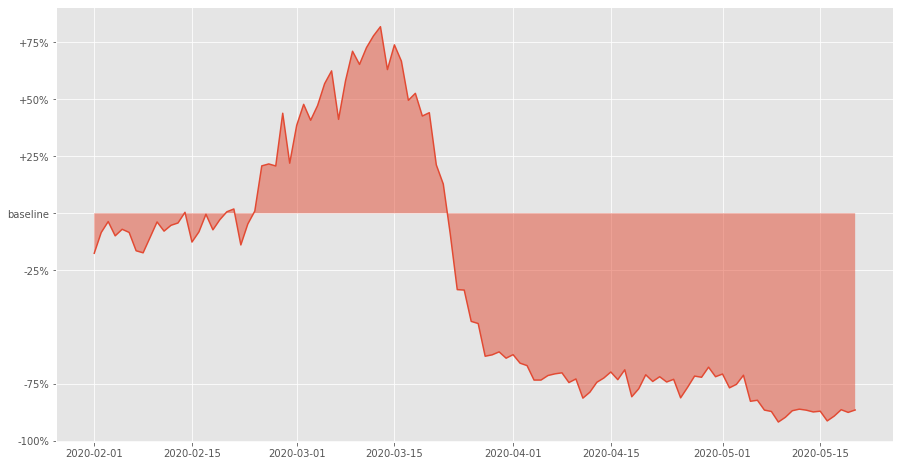

In [22]:
plt.figure(figsize = (15,8))
plt.plot(flights_daily['compare_to_baseline'])
plt.yticks([-100, -75, -25, 0, 25, 50, 75], 
           ['-100%', '-75%', '-25%', 'baseline', '+25%', '+50%', '+75%'])
plt.fill_between(flights_daily['compare_to_baseline'].index, 0, flights_daily['compare_to_baseline'].values, alpha=0.5)

In [23]:
# flights going out of Canada
flights_out = no_cancel[(no_cancel.from_country == 'Canada') & (no_cancel.to_country != 'Canada')].resample('1d').registration.count()

# flights flying in Canada
flights_in = no_cancel[(no_cancel.from_country != 'Canada') & (no_cancel.to_country == 'Canada')].resample('1d').registration.count()

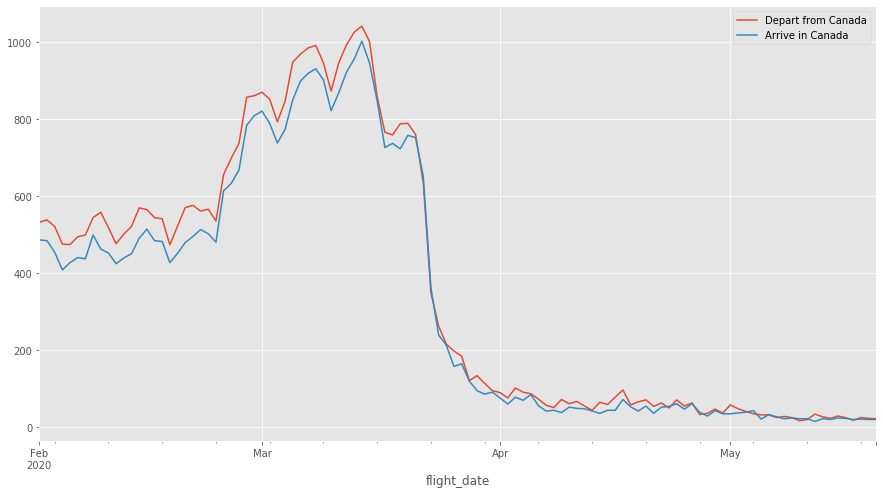

In [24]:
plt.figure(figsize = (15,8))
_ = flights_out.plot(label = 'Depart from Canada')
_ = flights_in.plot(label = 'Arrive in Canada')
_.legend()

## No. of flights by major airline companies

A National Post article titled '<a href = 'https://business.financialpost.com/transportation/why-an-ultra-low-cost-airline-cant-get-off-the-ground-in-canada'>Why Canada is the only major market in the world without a super-cheap airline</a>' indicated in 2016 that Canada's airline market was dominated by two companies: Air Canada and WestJet. 

In [25]:
# Create a new df with each row representing how many flights were operated by a compnay on a particular day
company_daily = pd.DataFrame(no_cancel.groupby('company').resample('1d').registration.count()).reset_index()

# Convert the long-narrow table into a wide-short table. 
# Alo some compnay doesn't have a single flight on certain days.
# Panda consider values on those days as null 
# Turn these null values into 0
company_daily = company_daily.pivot(index = 'flight_date', columns = 'company', values = 'registration').fillna(0)

# All the numbers are float. Turn them into integers
for column in company_daily.columns:
    company_daily[column] = company_daily[column].astype('int64')

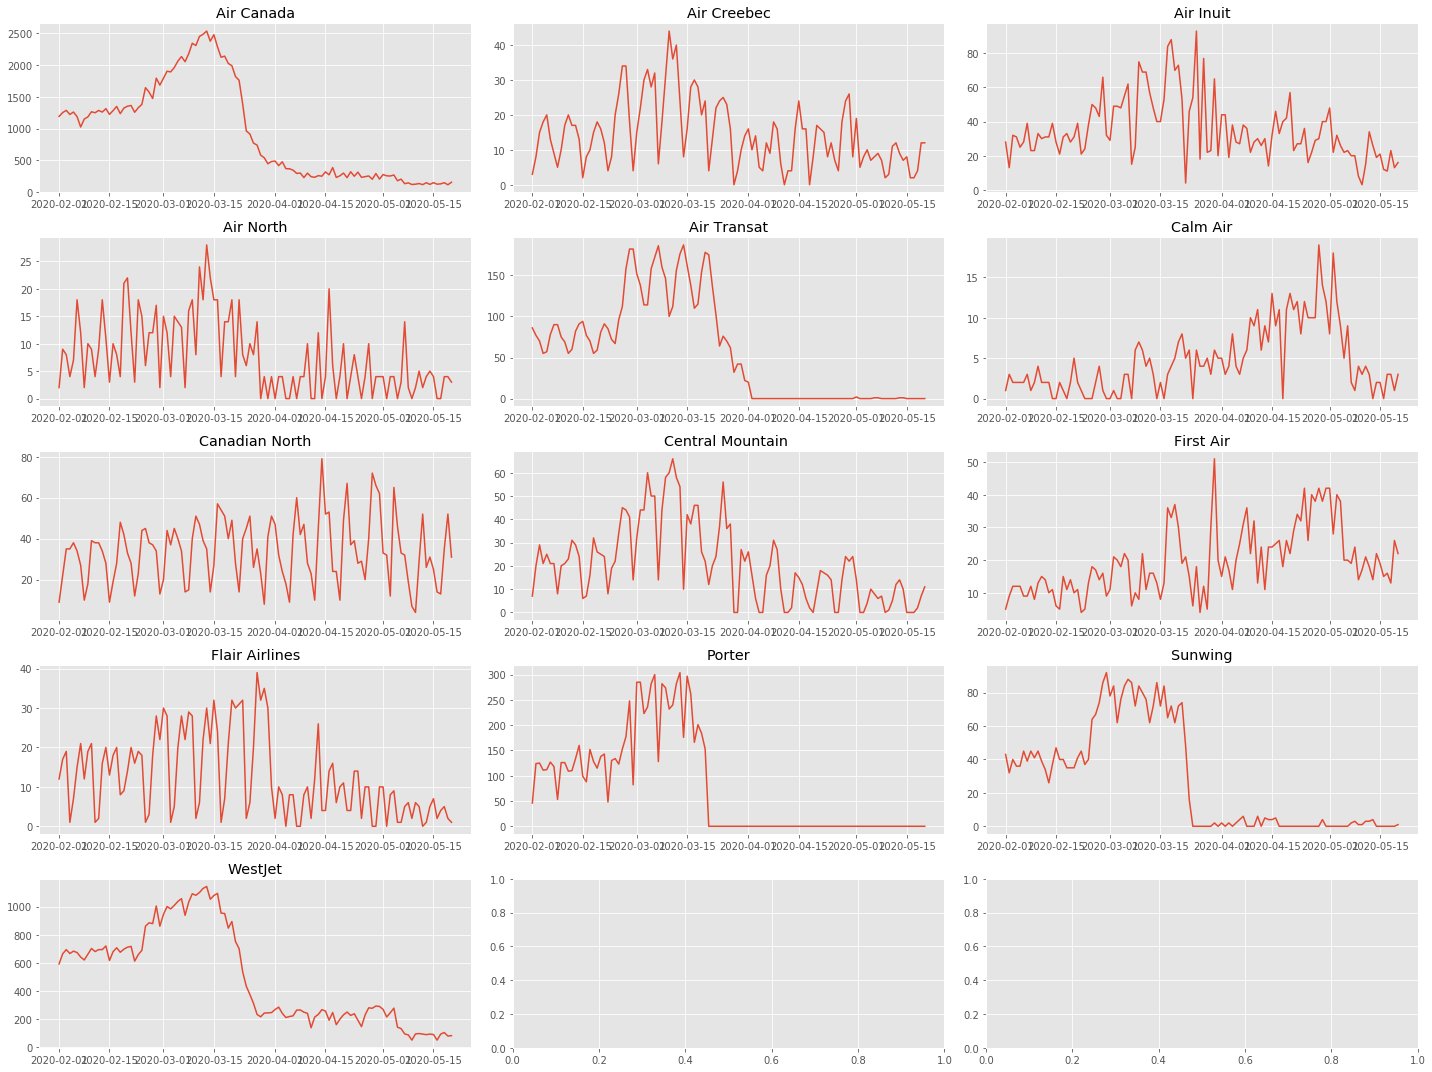

In [26]:
# Plot the daily number of flights company-by-company. Now they are all sharing the same x-axis
plt.subplots(5, 3, sharex = 'col',figsize = (20,15))
plot_num = 1
for column in company_daily.columns:
    plt.subplot(5,3, plot_num)
    plt.plot(company_daily[column])
    plt.title(column)
    plot_num +=1
plt.tight_layout()

Note: Porter Airline has suspended all their flights to the US since March 20. and will be restarted in June. Though, their flights within Canada also have been stopped. Therefore, as you can see from the chart, Porter's line chart stops on March 22. 

Comparing the absolute number can be misleading and hiding real patterns as there are major airlines owning hundreds of aircrafts and small companies operating single-digit-number of planes. A better method is to look at how many percentage of their fleets are in the sky. The percentage is calculated by diving the number of aircrafts in operation in a day with the total fleets. 

Note: one plane may take several trips in a day which is counted as one flight in operation.

In [27]:
# how many aircrafts are used on a daily basis by each compnay by counting unique sum of registration numbers
# since one plane can operate more than one trip in a given day. 
company_daily_unique = pd.DataFrame(no_cancel.groupby('company').resample('1d').registration.nunique().reset_index())
company_daily_unique = company_daily_unique.pivot(index = 'flight_date', columns = 'company', values = 'registration').fillna(0)

# convert the dataframe containing how many aircrafts each airline owns into the same format
company_fleets = pd.DataFrame(fleets.company.value_counts()).reset_index().\
rename(columns={'index': 'company', 'company': 'fleets'})
company_fleets = company_fleets.pivot_table(columns='company', values='fleets')

# Divide every column in flight history dataframe with columns of fleets dataframe
company_percent_daily = pd.DataFrame()
for column1, column2 in zip(company_daily_unique.columns, company_fleets.columns):
    company_percent_daily[column1] = (company_daily_unique[column1].values/company_fleets[column2].values[0]).round(4)* 100

company_percent_daily.set_index(company_daily_unique.index, inplace=True)

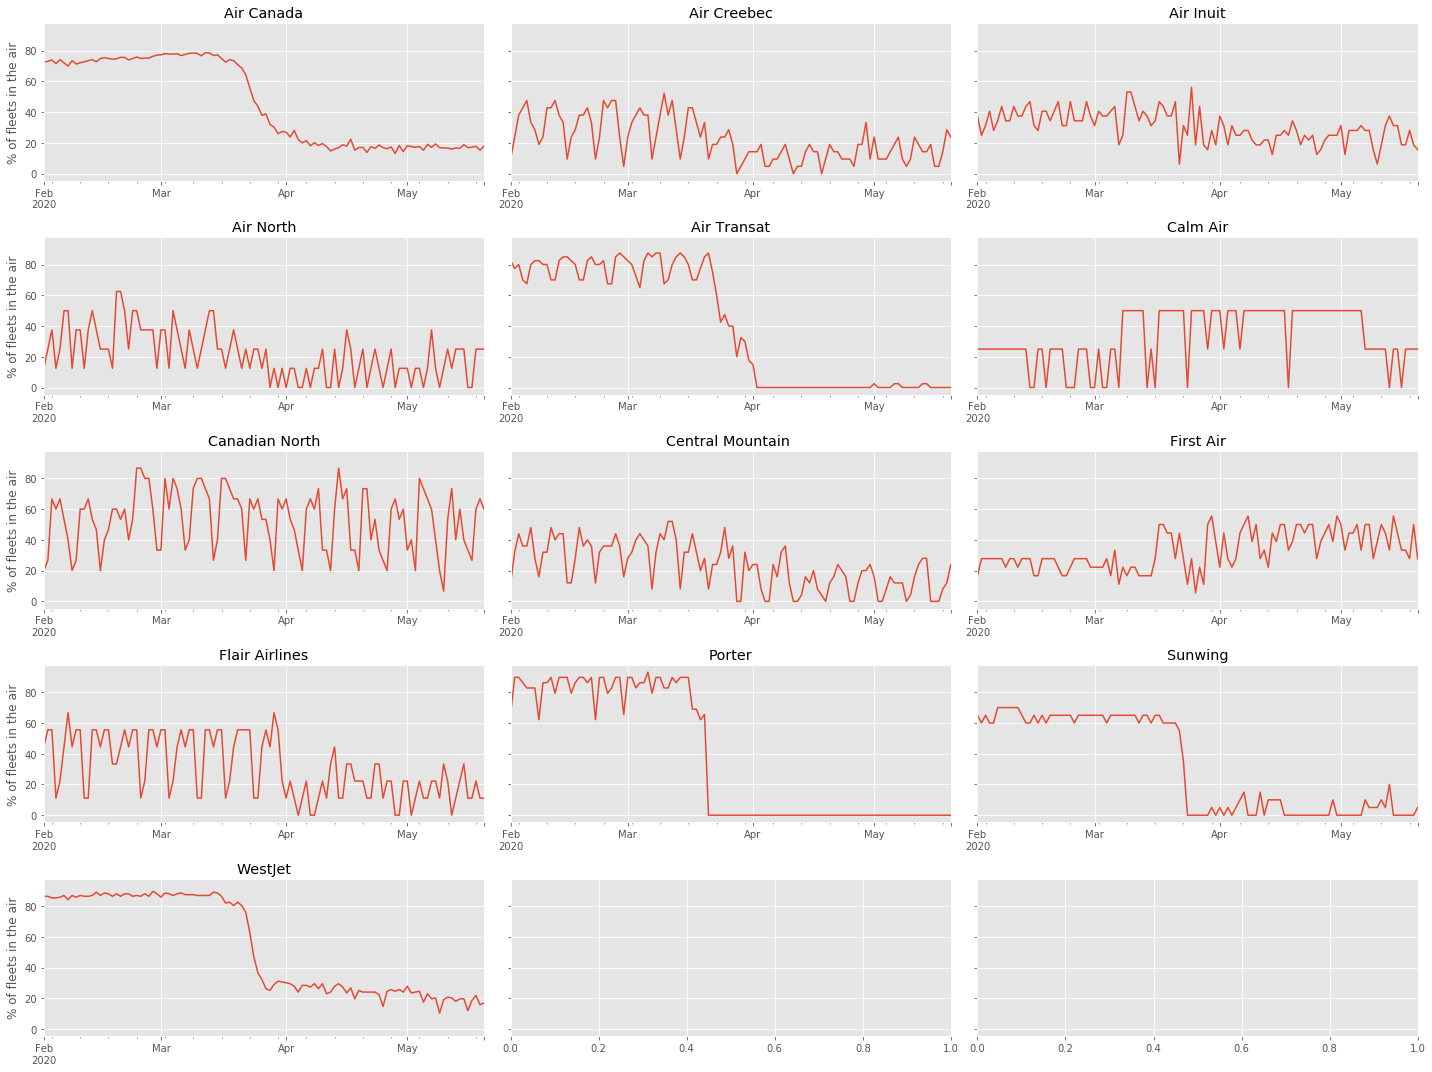

In [28]:
fig, axes = plt.subplots(5, 3, sharey=True, figsize = (20,15))
axes_list = [item for sublist in axes for item in sublist] 
ax_num = 0
for column in company_percent_daily.columns:
    ax = axes_list[ax_num]
    ax_num +=1
    company_percent_daily[column].plot(x=company_percent_daily[column].index, 
                                       y=company_percent_daily[column].values, 
                                       label=column, 
                                       ax=ax)
                                       
                                       
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('% of fleets in the air')
plt.tight_layout()

## No. of domestic and international flights

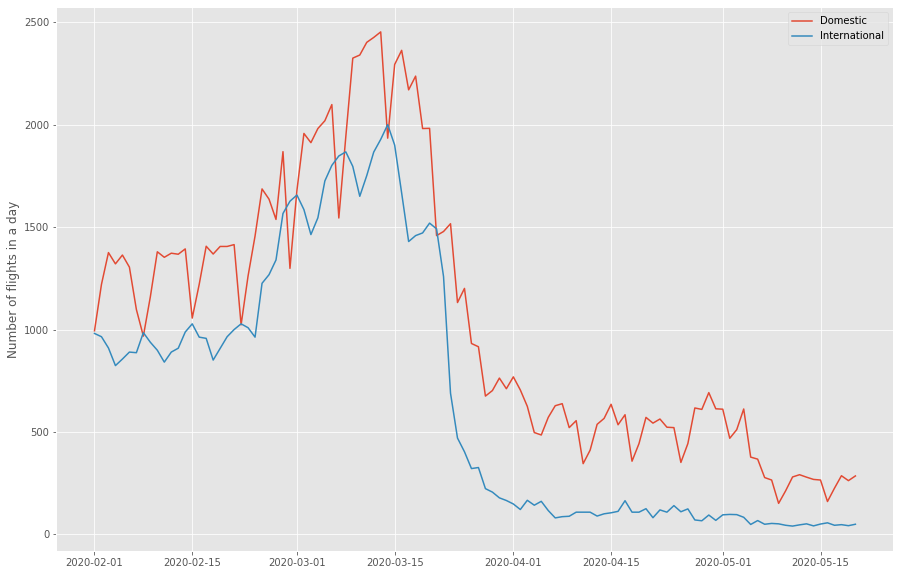

In [29]:
plt.figure(figsize = (15, 10))

_ = plt.plot(no_cancel[no_cancel.flight_type == 'domestic'].resample('1d').registration.count(), label = 'Domestic')
_ = plt.plot(no_cancel[no_cancel.flight_type == 'international'].resample('1d').registration.count(), label = 'International')


plt.ylabel('Number of flights in a day')
plt.legend()
plt.show()

## Cancellation

Text(0, 0.5, 'Cancellation rate by day')

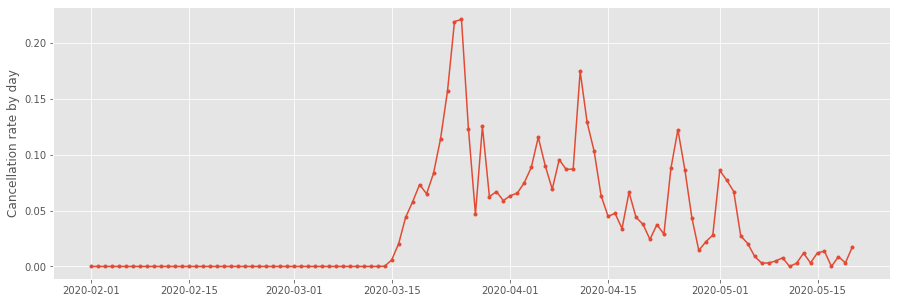

In [75]:
# cancellation rate by day
can_rate = pd.DataFrame((flights_frame[flights_frame['status_clean'] == 'Canceled'].resample('1d').registration.count())/\
             (flights_frame.resample('1d').registration.count())).\
            rename(columns = {'registration': 'cancellation_rate'}).fillna(0)

plt.figure(figsize = (15, 5))
plt.plot(can_rate, marker = '.')
plt.ylabel('Cancellation rate by day')

In [76]:
# Daily cancellation by domestic flights and international flights
domestic_can = flights_frame[(flights_frame['flight_type'] == 'domestic') & (flights_frame['status_clean'] == 'Canceled')]
international_can = flights_frame[(flights_frame['flight_type'] == 'international') & (flights_frame['status_clean'] == 'Canceled')]

In [77]:
domestic_can_rate = pd.DataFrame(domestic_can.resample('1d').registration.count()/\
                    (flights_frame[flights_frame['flight_type'] == 'domestic'].resample('1d').registration.count()))\
                    .rename(columns = {'registration': 'cancellation_rate'}).fillna(0)

international_can_rate = pd.DataFrame(international_can.resample('1d').registration.count()/\
                    (flights_frame[flights_frame['flight_type'] == 'international'].resample('1d').registration.count()))\
                    .rename(columns = {'registration': 'cancellation_rate'}).fillna(0)

Text(0, 0.5, 'Cancellation rate by day')

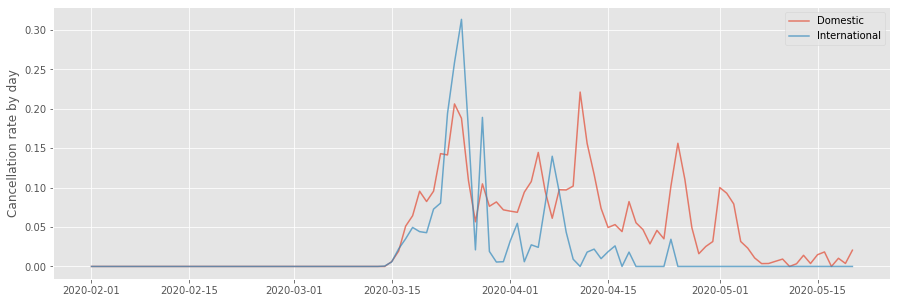

In [78]:
# plot the two cancellation rates 
plt.figure(figsize = (15, 5))
_ = plt.plot(domestic_can_rate, label = 'Domestic', alpha = 0.7)
_ = plt.plot(international_can_rate, label = 'International', alpha = 0.7)
plt.legend()
plt.ylabel('Cancellation rate by day')

# Airport Analysis
This section take a closer look at airports of all sizes in Canada — how many flights take off every day since March. The dataset covers 247 airports and 65 days.

In [169]:
# import all airport stats (april and may)
airport_files = glob.glob('data_clean/airport_stats/*.csv')

airport_files_list = []

for file in airport_files:
    df = pd.read_csv(file, index_col = 0)
    airport_files_list.append(df)
    
airport_stats = pd.concat(airport_files_list)

airport_stats.drop_duplicates(inplace=True)
# the above line drops rows with all cells identical
# there are rows have same date, airport, but different number of shceduled flights
# this is caused because of repeated scrapping at several times
# the scraper captures changes on the webpages.
# Therefore we have to remove older version and keep the updated information
# standard: when the date and airport code are the same, remove the line with fewer number od scheduled flights

airport_stats = airport_stats.groupby(['date', 'code', 'name']).max().reset_index()

In [170]:
airport_stats['date'] = pd.to_datetime(airport_stats['date'])
# airport_stats.set_index('date', inplace=True)

## Major Airports 

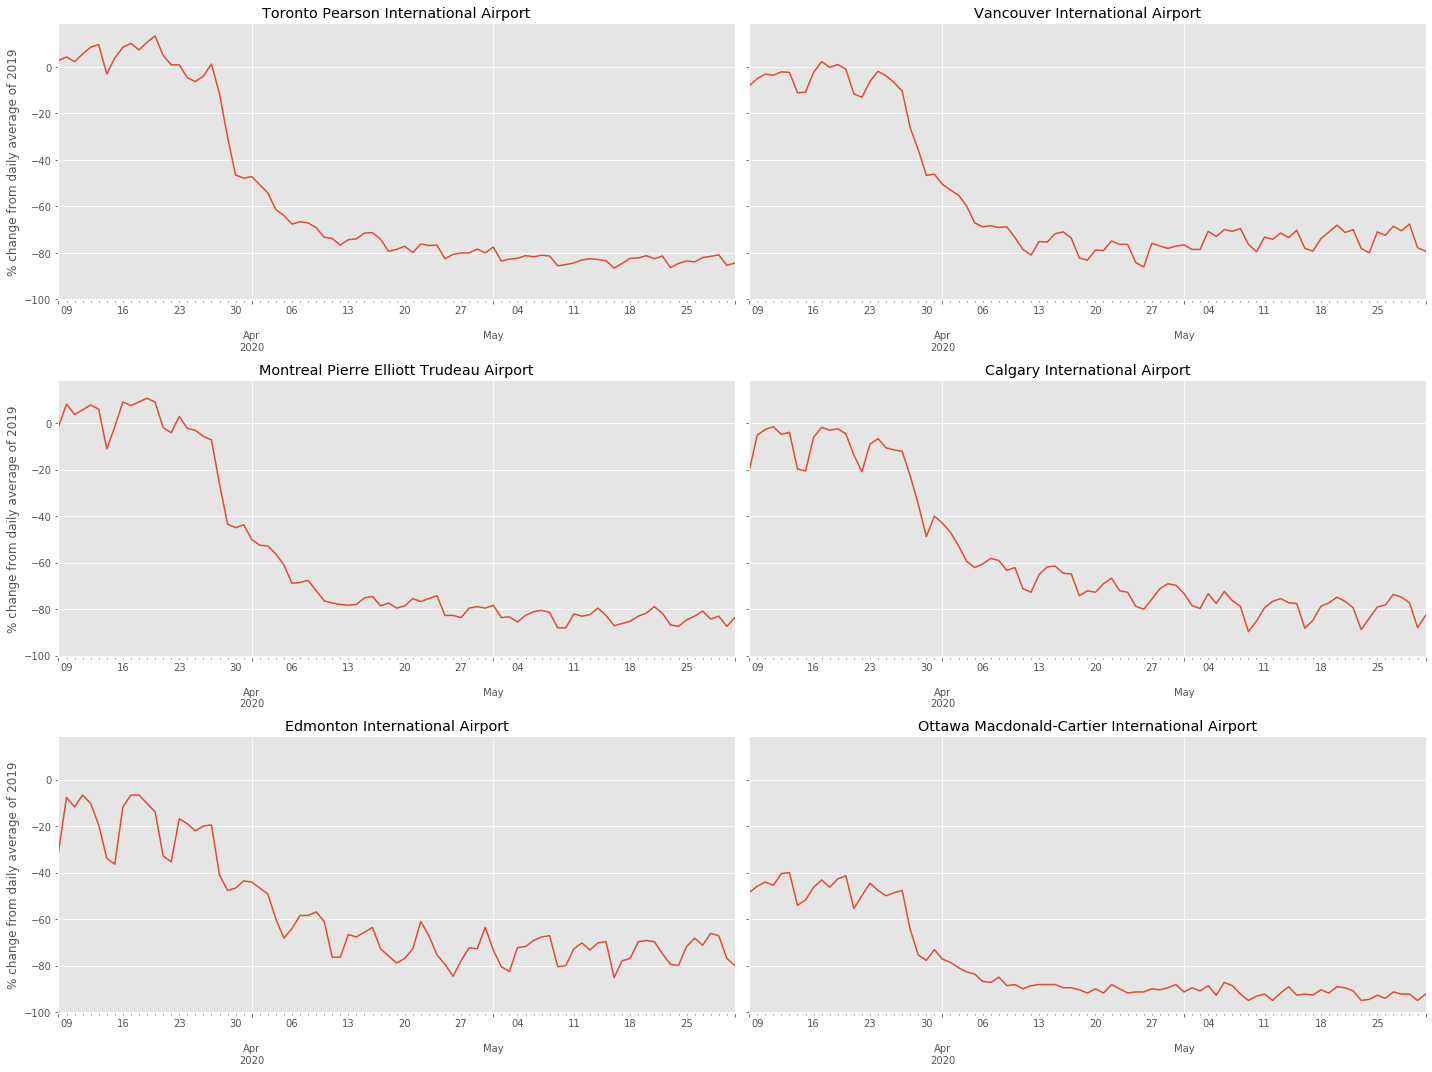

In [309]:
# Major aiports in Canada
airport_major = ['YYZ', 'YVR', 'YUL','YYC', 'YEG', 'YOW']
# aircraft movement data source: 
#https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_Canada
daily_departure = [597, 411, 318, 330, 195, 220]

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(20,15))
# the axes in the subplots are a set of arrays. 
# turn the arrays into a list uselist comprehension to iterate
axes_list = [item for sublist in axes for item in sublist]
list_index = 0
for airport, departure in zip(airport_major, daily_departure):
    df = airport_stats[airport_stats['code'] == airport].set_index('date')
    df['change'] = ((df['scheduled_flights'] - departure)/departure * 100).round(2)
    ax = axes_list[list_index]
    list_index +=1
    df['change'].plot(ax = ax)
    ax.set_title(df['name'][0])
    ax.set_xlabel('')
    ax.set_ylabel('% change from daily average of 2019')
plt.tight_layout()